<p style='color:#af0fa2; font-size:32px; text-align:left'> <strong> Transcript analyses  </strong>
</p>
<p style='color:grey; font-size:20px; text-align:right'>Natural Language Processing treatment and supervised ML </p>

<!-- 
 <p style="color:#af0fa2;"> 
✔ Data preprocessing<br>
✔ Training set/Testing set/Validation set <br>
✔ Model/Hyperparameters optimization <br>
✔ Training of the model  <br>
✔ Evaluation of the model <br>
✔ Classifications <br>
</p> -->

In [8]:
import pandas as pd 
from nltk.corpus import abc
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from collections import defaultdict
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc
np.random.seed(42)
from pprint import pprint
import altair as alt
# alt.renderers.enable("notebook")

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from spacy.lang.en.stop_words import STOP_WORDS

In [3]:
stopwords_spacy=list(STOP_WORDS)

In [4]:
transcript=pd.read_csv('/home/alex/SimplonIA/Enfer/Projet_ML/data/overview-of-recordings.csv', sep=',')

In [551]:
transcript.head(2)

audio_clipping  audio_clipping:confidence background_noise_audible  \
0     no_clipping                     1.0000              light_noise   
1  light_clipping                     0.6803                 no_noise   

   background_noise_audible:confidence  overall_quality_of_the_audio  \
0                               1.0000                          3.33   
1                               0.6803                          3.33   

     quiet_speaker  quiet_speaker:confidence  speaker_id  \
0  audible_speaker                       1.0    43453425   
1  audible_speaker                       1.0    43719934   

                                       file_download  \
0  https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...   
1  https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...   

                       file_name  \
0  1249120_43453425_58166571.wav   
1  1249120_43719934_43347848.wav   

                                              phrase          prompt  \
0                    When I remember her I feel down  Emotional pain   
1  When I carry heavy things I feel like breaking...       Back pain   

   writer_id                                   phrase_transform  \
0   21665495                    When I remember her I feel down   
1   44088126  When I carry heavy things I feel like breaking...   

   record_words_count  
0                   7  
1                  11

In [558]:
transcript_to_save=transcript[["phrase", "prompt"]]
csv_transcripts =transcript_to_save.to_csv("csv_transcripts.csv")

In [407]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                        6661 non-null   object 
 6   quiet_speaker:confidence             6661 non-null   float64
 7   speaker_id                           6661 non-null   int64  
 8   file_download                        6661 non-null   object 
 9   file_name                            6661 non-null   object 
 10  phrase                               6661 non-null   object 
 11  prompt                        

In [28]:
transcript_graph=transcript.copy()
transcript_graph.rename(columns={'prompt': 'Symptom class', 'phrase': 'Pronounced phrase'}, inplace=True)

In [64]:
#testing a new library
alt.data_transformers.disable_max_rows()
bars = alt.Chart(transcript_graph).mark_bar(size=25).encode(
    x=alt.X("Symptom class"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of pronounced phrases')),
    tooltip=[alt.Tooltip('count()', title='Number of pronounced phrase'), 'Symptom class'],
    color='Symptom class'

)
text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=650,
    title = "Number of pronounced phrases in each symptom class",
)


alt.LayerChart(...)

In [46]:
records_par_symptom_type=pd.DataFrame(transcript.groupby("prompt").count().reset_index())[["prompt", "phrase"]]

In [48]:
records_par_symptom_type.rename(columns={'prompt': 'Symptom_class', 'phrase': 'Pronounced_phrase'}, inplace=True)

In [67]:
bars = alt.Chart(records_par_symptom_type).mark_bar(size=25).encode(
    x=alt.X('Symptom_class'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Phrases')),
    color='Symptom_class'
).transform_window(
    TotalPhrases='sum(Pronounced_phrase)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.Pronounced_phrase / datum.TotalPhrases"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=350, 
    width=650,
    title = "% of phrases in each symtom class",
)

alt.LayerChart(...)

<p style='color:#af0fa2; font-size:25px; text-align:left'> <strong> Preparation of the data  </strong>
</p>

In [412]:
transcript.loc[transcript['phrase'] == 'When I carry heavy things I feel like breaking my back', 'prompt'] = "Back pain"

In [12]:
transcript.loc[transcript['phrase'] == 'My muscles in my lower back are aching', 'prompt'] = "Muscle pain"

In [13]:
transcript.loc[transcript['phrase'] == 'I have muscle pain in my left leg', 'prompt'] = "Muscle pain"

In [14]:
transcript.loc[transcript['phrase'] == 'I have a strange rash on my arm', 'prompt'] = "Skin issue"

In [15]:
transcript.loc[transcript['phrase'] == "Don't cry", 'prompt'] = "Emotional pain"

In [16]:
transcript.loc[transcript['phrase'] == "i cant sleep because of cold", 'prompt'] = "Feeling cold"

In [17]:
transcript.loc[transcript['phrase'] == "My infected wound cause fever", 'prompt'] = "Infected wound"

In [18]:
transcript.loc[transcript['phrase'] == "I lose a lot of my hair", 'prompt'] = "Hair falling out"

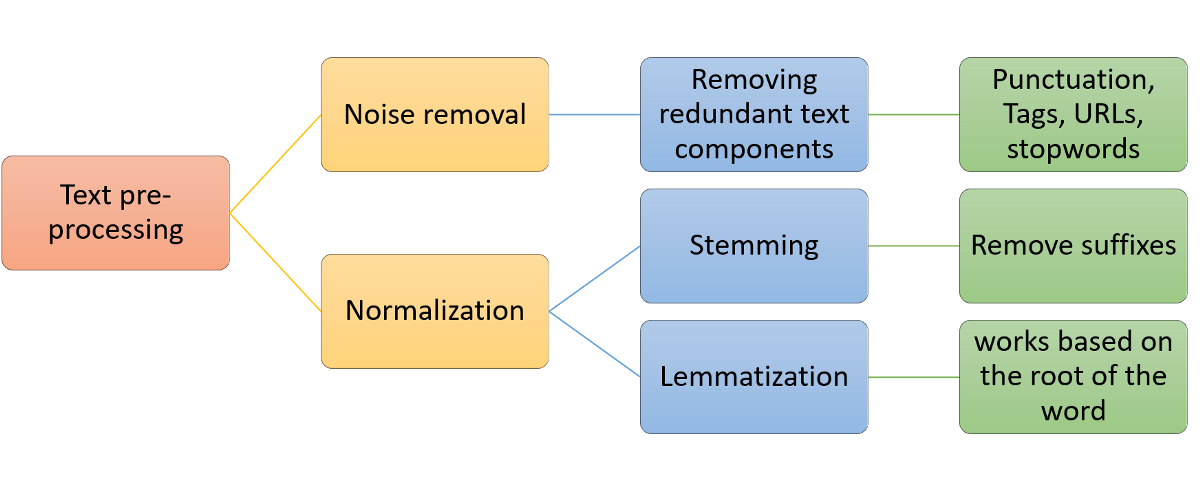

In [68]:
import re
string_to_replace = ["can't"]
string_to_replace_2 = ["doesn't"]
regex_string = r"|".join(string_to_replace)
regex_string_2 = r"|".join(string_to_replace_2)
# 0 strip the string from both sides from the whitespaces
# 1. introduce a whitespace after  , et  ;
# 2. strip whitespace from before but not after punctuation et - et + 
transcript['phrase_transform'] = transcript['phrase'].apply(lambda x: str(x).strip().lower())
transcript['phrase_transform'] = transcript['phrase'].apply(lambda x: re.sub(r'(?<=[,;])(?=[^\s])', r' ',str(x)))
transcript['phrase_transform'] = transcript['phrase'].apply(lambda x: re.sub(r'\s([-,.;+:"](?:\s|$))', r'\1',str(x)))
transcript['phrase_transform'] = transcript['phrase_transform'].apply(lambda x: re.sub(regex_string, "cannot", str(x), flags=re.I))
transcript['phrase_transform'] = transcript['phrase_transform'].apply(lambda x: re.sub(regex_string_2, "doesnot", str(x), flags=re.I))

In [70]:
transcript['record_words_count'] = transcript['phrase'].apply(lambda x: len(str(x).split(" ")))
transcript[['phrase','record_words_count']].head()
transcript['record_words_count'].describe()

count    6661.000000
mean       10.592253
std         4.866114
min         2.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        30.000000
Name: record_words_count, dtype: float64

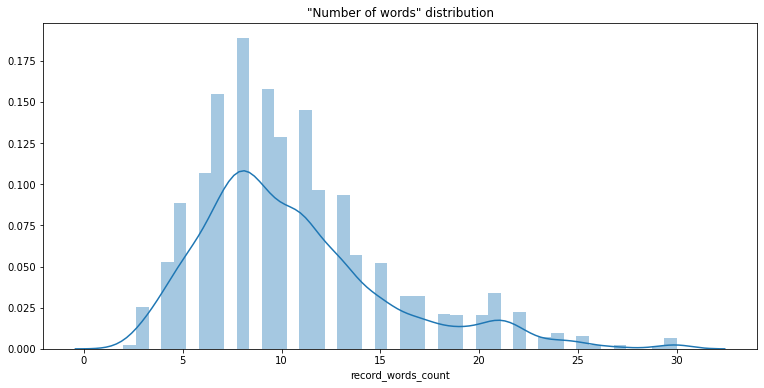

In [74]:
plt.figure(figsize=(12.8,6))
sns.distplot(transcript['record_words_count']).set_title('"Number of words" distribution');

In [424]:
transcript["quiet_speaker"].value_counts()

audible_speaker    6646
quiet_speaker        15
Name: quiet_speaker, dtype: int64

In [425]:
transcript["phrase_transform"].values[118]

'Every time I take a deep breath I start coughing'

In [426]:
stop = stopwords.words('english')
trans_phr_analys=transcript.copy()

In [427]:
len(stop), len(stopwords_spacy)

(179, 326)

In [428]:
stop_words_list=[word for word in stopwords_spacy if word not in stop]

In [429]:
len(stop_words_list)

203

In [430]:
stop_words_list=stop_words_list+stop
len(stop_words_list)

382

In [431]:
specific_stop_words=["dr", "cant", "book", "read", "son", 'daughter', "after", "alot", 
                     "name", "phrase", "thing", "father", "brother", "sister", "mother",
                     "others", "dtype", "length", "look", "object", "hour", "object", 
                     "shoelace", "medicine", "paper", "cube", "bag", 'said', "rainy",
                     "soda", "playing", "apply", "parent", "tuesday", "monday", "tuesday",
                     "maybe", "friday", "wednesday", "thursday", "friday", "saturday", 
                     "sunday", "nut", "identify", "waking"]

In [432]:
specific_stop_words_to_remove_from_stopwords=["back", "down", "see", "well", "doesnot","cannot"]

In [433]:
def remove_stop_words(list_stop_wd, wd):
    if not list_stop_wd:
        print("The list of stopwords is empty")
        return []
    if(wd in list_stop_wd):
        list_stop_wd.remove(wd)
    return list_stop_wd

In [434]:
def add_stop_words(list_stop_wd, wd):
    if not list_stop_wd:
        print("The list of stopwords is empty. Adding the word" + str(wd))
        return [str(wd)]
    if(wd not in list_stop_wd):
        list_stop_wd.append(str(wd))
    return list_stop_wd

In [435]:
for wd in specific_stop_words_to_remove_from_stopwords:
    stop_words_list=remove_stop_words(stop_words_list, wd)

In [436]:
for wd in specific_stop_words:
    stop_words_list=add_stop_words(stop_words_list, wd)

In [437]:
len(stop_words_list)

417

In [438]:
"look" in stop_words_list

True

In [439]:
#Removing Punctuation;
tokenizer = nltk.RegexpTokenizer(r'\w+')
translator = str.maketrans('', '', string.punctuation)

In [440]:
trans_phr_analys["phrase_transform"] = trans_phr_analys["phrase_transform"].apply(lambda x: " ".join(x for x in tokenizer.tokenize(str(x))))

In [441]:
trans_phr_analys["phrase_transform"]

0                         When I remember her I feel down
1       When I carry heavy things I feel like breaking...
2               there is too much pain when i move my arm
3       My son had his lip pierced and it is swollen a...
4                  My muscles in my lower back are aching
                              ...                        
6656    I feel a burning sensation in my guts about 2 ...
6657        I have a split on my thumb that will not heal
6658                   I feel a lot of pain in the joints
6659           The area around my heart doesnot feel good
6660                    I complain alot with skin allergy
Name: phrase_transform, Length: 6661, dtype: object

In [442]:
frequency_first=pd.Series(' '.join(trans_phr_analys["phrase_transform"]).split()).value_counts()[:50]
frequency_last=pd.Series(' '.join(trans_phr_analys["phrase_transform"]).split()).value_counts()[-50:]

In [443]:
frequency_first

I           6257
my          3472
a           2098
in          1964
have        1606
pain        1586
and         1528
feel        1527
the         1306
is          1219
My          1219
i           1121
to          1009
when         975
it           897
of           804
cannot       596
on           591
up           510
like         507
hurts        460
When         449
get          409
that         408
with         404
back         387
me           371
m            348
was          346
out          305
hair         300
shoulder     300
after        295
but          293
head         291
cold         291
knee         289
an           284
body         275
neck         272
feels        270
skin         257
ache         255
s            253
stomach      244
not          242
t            241
heart        236
so           234
foot         227
dtype: int64

<p style='color:#af0fa2; font-size:16px; text-align:left'> <strong> Create a vocabulary and generate word counts  </strong>
</p>

In [444]:
def preprocessing_records_v3 (text):
    text=text.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
#remove tags
    text=re.sub("</?.*?>"," <> ",text) 
    return text

In [445]:
trans_phr_analys["phrase_transform"] = trans_phr_analys["phrase_transform"].apply(lambda x:preprocessing_records_v3(x))

In [446]:
all_records=trans_phr_analys["phrase_transform"].tolist()

In [447]:
#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv=CountVectorizer(max_df=0.85,stop_words=stop_words_list)
word_count_vector=cv.fit_transform(all_records)

In [448]:
word_count_vector

<6661x952 sparse matrix of type '<class 'numpy.int64'>'
	with 30068 stored elements in Compressed Sparse Row format>

In [449]:
word_count_vector.shape

(6661, 952)

In [450]:
set(list(cv.vocabulary_.keys())[:20])

{'arm',
 'back',
 'breaking',
 'carry',
 'down',
 'feel',
 'grey',
 'heavy',
 'infected',
 'inside',
 'like',
 'lip',
 'looks',
 'muscles',
 'pain',
 'pierced',
 'remember',
 'skin',
 'swollen',
 'things'}

In [451]:
#Vocabulary - another way to get it
list(cv.get_feature_names())[100:112]

['brows',
 'brush',
 'buckled',
 'bunches',
 'burning',
 'burns',
 'buttock',
 'button',
 'cage',
 'calm',
 'calve',
 'calves']

<p style='color:#af0fa2; font-size:16px; text-align:left'> <strong> Tf-idf Transformer to Compute Inverse Document Frequency (IDF)  </strong>
</p>

In [452]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
tfidf_transformer.idf_

array([7.50158993, 7.60695044, 7.50158993, 7.72473348, 7.60695044,
       6.54607848, 7.0315863 , 7.50158993, 7.85826487, 6.91380326,
       7.50158993, 6.85973604, 4.25899757, 5.36152376, 5.97553362,
       4.71657868, 6.80844275, 7.72473348, 7.60695044, 7.40627975,
       7.60695044, 7.60695044, 6.11529556, 7.40627975, 7.72473348,
       7.31926837, 7.40627975, 7.50158993, 5.27157553, 7.50158993,
       7.40627975, 7.40627975, 7.85826487, 7.31926837, 6.62612119,
       7.85826487, 7.31926837, 7.60695044, 6.33843912, 5.03349039,
       6.43687919, 7.60695044, 7.85826487, 6.75965258, 7.23922566,
       7.23922566, 5.77882333, 7.40627975, 7.50158993, 7.40627975,
       3.84575033, 5.77882333, 5.67704063, 7.60695044, 7.50158993,
       6.91380326, 6.47197051, 6.37018781, 7.40627975, 7.31926837,
       7.40627975, 7.60695044, 7.40627975, 7.23922566, 5.47344168,
       7.50158993, 5.67704063, 6.43687919, 7.60695044, 6.33843912,
       7.0315863 , 7.50158993, 7.50158993, 7.40627975, 6.06650

<p style='color:#af0fa2; font-size:16px; text-align:left'> <strong> Extracting key words  </strong>
</p>

In [453]:
features=cv.get_feature_names()

In [454]:
#first record
all_records[0]

'when i remember her i feel down'

In [455]:
#generate tf-idf for the given record
tf_idf_vector=tfidf_transformer.transform(cv.transform([all_records[1]]))

In [456]:
tf_idf_vector.tocoo().data, tf_idf_vector.tocoo().col

(array([0.43549419, 0.27111635, 0.379967  , 0.18662197, 0.46275881,
        0.50940983, 0.28981712]),
 array([832, 497, 384, 293, 120,  89,  50], dtype=int32))

In [457]:
#sort the tf-idf vectors by descending order of scores
def sorting(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [458]:
#sort the tf-idf vectors by descending order of scores
sorted_items=sorting(tf_idf_vector.tocoo())

In [459]:
def extract_keywords(features, sorted_items, how_many=10):
    sorted_items = sorted_items[:how_many]
# """get the feature names and tf-idf score of top n items"""
#use only topn items from vector
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = features[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(features[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results    

In [460]:
#extract only the top n; n here is 10
keywords=extract_keywords(features,sorted_items,20)

In [461]:
for k in keywords:
    print(k,keywords[k])

breaking 0.509
carry 0.463
things 0.435
heavy 0.38
back 0.29
like 0.271
feel 0.187


In [462]:
tf_idf_vector[0]

<1x952 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [463]:
df_scores = pd.DataFrame(tf_idf_vector[0].T.todense(), index=features, columns=["tf-idf"])
df_scores.sort_values(by=["tf-idf"],ascending=False).head(10)

tf-idf
breaking   0.509410
carry      0.462759
things     0.435494
heavy      0.379967
back       0.289817
like       0.271116
feel       0.186622
powerful   0.000000
practice   0.000000
pregnancy  0.000000

In [464]:
def extract_keywords_from_records(all_records):
     
    cv=CountVectorizer(max_df=0.85,stop_words=stop_words_list)
    word_count_vector=cv.fit_transform(all_records)
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    
    features=cv.get_feature_names()
    
    tf_idf_vectors=[tfidf_transformer.transform(cv.transform([all_records[i]])) for i in range(len(all_records))]
    
    sorted_items_list=[sorting(tf_idf_vector.tocoo()) for tf_idf_vector in tf_idf_vectors]
    
    keywords_list=[extract_keywords(features,sorted_items,10) for sorted_items in sorted_items_list]
    
    return keywords_list

In [465]:
 keywords_list=extract_keywords_from_records(all_records)

In [466]:
captions_list=["record"+str(i) for i in range(len(keywords_list))]
len(captions_list)

6661

In [467]:
for k in keywords:
    print(k,keywords[k])

breaking 0.509
carry 0.463
things 0.435
heavy 0.38
back 0.29
like 0.271
feel 0.187


In [468]:
def transform_dict_to_df(d):
    return pd.DataFrame.from_dict(d, orient='index', columns=["tf-idf scores"])

In [469]:
transform_dict_to_df(keywords_list[0])

tf-idf scores
remember          0.804
down              0.528
feel              0.272

In [470]:
from IPython.core.display import display, HTML

def display_side_by_side(dicts:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    
    dicts_df=[transform_dict_to_df(d) for d in dicts]

    combined = dict(zip(captions, dicts_df))        
    for caption, dictionary in combined.items():
        output += dictionary.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [474]:
# # # # # #run it in local, very large output
# display_side_by_side(keywords_list, captions_list)

In [475]:
all_records[6284]

'when i get out of bed in the morning my body feels very weak'

In [476]:
def pickup_a_record_for_print(number):
# now print the results
    print("\n=====Record=====")
    print(all_records[number])
    print("\n=====Asigned label=====")
    print(trans_phr_analys["prompt"].iloc[number])
    print("\n===Keywords===")
    display_side_by_side([keywords_list[number]], [captions_list[number]])

In [477]:
pickup_a_record_for_print(200)


=====Record=====
my knees hurt so bad to walk that i stay sitting more than i should

=====Asigned label=====
Knee pain

===Keywords===


In [478]:
n=input("Picup a record to print ")
pickup_a_record_for_print(int(n))

Picup a record to print 1

=====Record=====
when i carry heavy things i feel like breaking my back

=====Asigned label=====
Back pain

===Keywords===


<p style='color:#af0fa2; font-size:25px; text-align:left'> <strong> Summary 
    </strong>
</p>

In [479]:
vocabulary=cv.vocabulary_
{k: v for k, v in sorted(vocabulary.items(), key=lambda item: item[1])}

{'10': 0,
 '100': 1,
 '15': 2,
 '500m': 3,
 '70': 4,
 'abdomen': 5,
 'abdominal': 6,
 'able': 7,
 'abronchial': 8,
 'accident': 9,
 'accidentally': 10,
 'accompanied': 11,
 'ache': 12,
 'aches': 13,
 'aching': 14,
 'acne': 15,
 'active': 16,
 'actually': 17,
 'acupuncture': 18,
 'adult': 19,
 'affected': 20,
 'afraid': 21,
 'ago': 22,
 'agreat': 23,
 'air': 24,
 'allergy': 25,
 'analysis': 26,
 'anemia': 27,
 'ankle': 28,
 'annoyance': 29,
 'annoying': 30,
 'annoys': 31,
 'answer': 32,
 'antibiotic': 33,
 'anymore': 34,
 'anytime': 35,
 'appendicitis': 36,
 'arches': 37,
 'area': 38,
 'arm': 39,
 'arms': 40,
 'arrived': 41,
 'asthma': 42,
 'ate': 43,
 'attack': 44,
 'awake': 45,
 'away': 46,
 'awful': 47,
 'b12': 48,
 'bacause': 49,
 'back': 50,
 'bad': 51,
 'badly': 52,
 'bald': 53,
 'ball': 54,
 'barely': 55,
 'basketball': 56,
 'bear': 57,
 'beating': 58,
 'bed': 59,
 'beeing': 60,
 'beginning': 61,
 'believe': 62,
 'belly': 63,
 'bend': 64,
 'bent': 65,
 'better': 66,
 'bicep': 67,

In [480]:
#generate tf-idf for all comments in the list. demandes has 8994 comments including NaN
tf_idf_vectors=tfidf_transformer.transform(cv.transform(all_records))

results=[]
for i in range(tf_idf_vectors.shape[0]):
    
    # get vector for a single record
    current_vector=tf_idf_vectors[i]
    
    #sort the tf-idf vector by descending order of scores
    sorted_items=sorting(current_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_keywords(features,sorted_items,10)

    results.append(keywords)

df_record=pd.DataFrame(zip(all_records,results),columns=['Record','Key words'])
df_record

Record  \
0                       when i remember her i feel down   
1     when i carry heavy things i feel like breaking...   
2             there is too much pain when i move my arm   
3     my son had his lip pierced and it is swollen a...   
4                my muscles in my lower back are aching   
...                                                 ...   
6656  i feel a burning sensation in my guts about 2 ...   
6657      i have a split on my thumb that will not heal   
6658                 i feel a lot of pain in the joints   
6659         the area around my heart doesnot feel good   
6660                  i complain alot with skin allergy   

                                              Key words  
0     {'remember': 0.804, 'down': 0.528, 'feel': 0.272}  
1     {'breaking': 0.509, 'carry': 0.463, 'things': ...  
2                         {'arm': 0.898, 'pain': 0.441}  
3     {'lip': 0.665, 'grey': 0.358, 'pierced': 0.333...  
4     {'aching': 0.57, 'muscles': 0.523, 'lower': 0....  
...                                                 ...  
6656  {'meal': 0.492, 'hours': 0.492, 'guts': 0.492,...  
6657    {'split': 0.632, 'thumb': 0.586, 'heal': 0.506}  
6658  {'joints': 0.682, 'lot': 0.577, 'feel': 0.317,...  
6659  {'area': 0.554, 'doesnot': 0.511, 'good': 0.49...  
6660  {'allergy': 0.678, 'complain': 0.621, 'skin': ...  

[6661 rows x 2 columns]

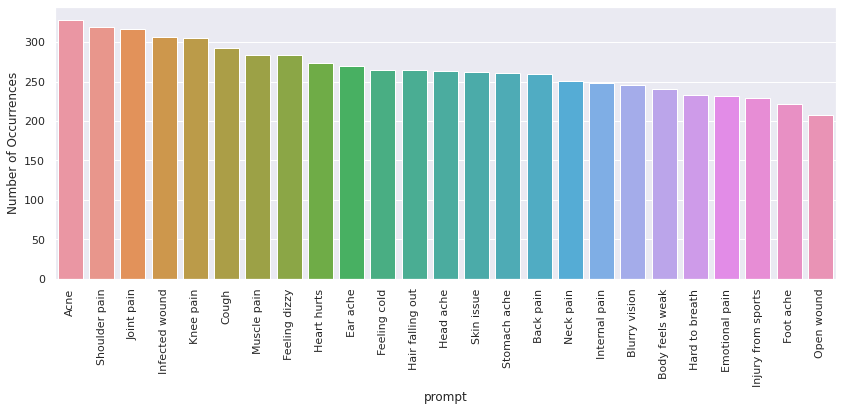

In [481]:
plt.figure(figsize=(14,5))
sns.barplot(x=trans_phr_analys["prompt"].value_counts().index, y=trans_phr_analys['prompt'].value_counts())
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('prompt', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [482]:
transcript["prompt"].unique()

array(['Emotional pain', 'Back pain', 'Heart hurts', 'Infected wound',
       'Muscle pain', 'Foot ache', 'Injury from sports', 'Skin issue',
       'Stomach ache', 'Knee pain', 'Hard to breath', 'Head ache',
       'Feeling cold', 'Hair falling out', 'Feeling dizzy', 'Open wound',
       'Internal pain', 'Body feels weak', 'Blurry vision', 'Acne',
       'Joint pain', 'Shoulder pain', 'Neck pain', 'Cough', 'Ear ache'],
      dtype=object)

<p style='color:#af0fa2; font-size:30px; text-align:left'> <strong> K-means  </strong>
</p>

In [483]:
tfidf_vectorizer  = TfidfVectorizer(min_df=2, stop_words=stop_words_list, use_idf=True, smooth_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(all_records)

In [484]:
tfidf_vectorizer_vectors.shape

(6661, 950)

In [485]:
feature_names = tfidf_vectorizer.get_feature_names()
vocabulary=tfidf_vectorizer.vocabulary_

In [486]:
km = KMeans(n_clusters=32)
kmeans = km.fit_predict(tfidf_vectorizer_vectors)

In [487]:
len(kmeans)

6661

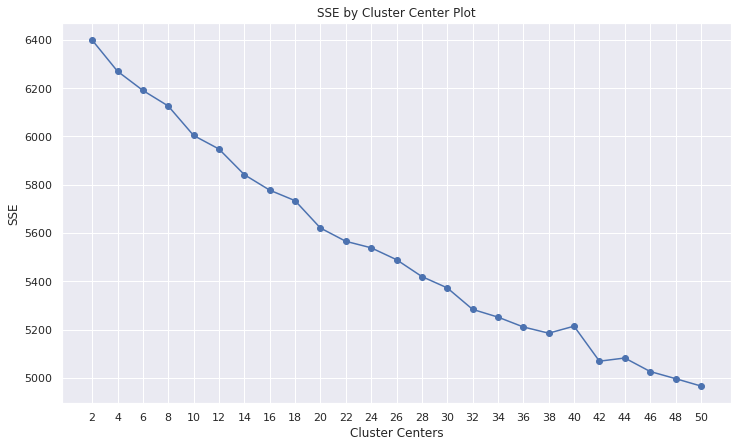

In [488]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, compute_labels=True, init_size=1024, batch_size=2048, random_state=42).fit(data).inertia_)    
    f, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(tfidf_vectorizer_vectors, 50)

In [489]:
clusters = MiniBatchKMeans(n_clusters=30, init_size=1024, batch_size=2048, 
                           random_state=42).fit_predict(tfidf_vectorizer_vectors)

In [490]:
km = KMeans(n_clusters=30)
kmeans = km.fit_predict(tfidf_vectorizer_vectors)

In [491]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
#get_top_keywords(tfidf_vectorizer_vectors, clusters, tfidf_vectorizer.get_feature_names(), 10)
get_top_keywords(tfidf_vectorizer_vectors, kmeans, tfidf_vectorizer.get_feature_names(), 20)


Cluster 0
throat,hurts,painful,left,focus,itches,see,aches,heal,joints,ears,strange,headache,time,injured,morning,cannot,hard,arm,feel

Cluster 1
nail,gym,needed,stitches,closed,toenails,clipped,showers,foot,oozes,hand,ago,swollen,couple,bleeding,puss,healing,red,infected,cut

Cluster 2
hurts,abdomen,sensation,think,arm,joints,time,left,internal,bicep,muscle,powerful,leg,cannot,inside,joint,sharp,feel,neck,pain

Cluster 3
day,bothers,night,soccer,badly,woke,gets,kicked,tired,dull,single,think,spinning,heavy,try,feel,hurts,pain,ache,head

Cluster 4
arm,doctor,fever,heal,wrong,suffered,surgical,cut,infection,infections,discovered,opened,bleeding,think,hand,coughing,stop,infected,open,wound

Cluster 5
laceration,rupture,complain,tried,inflamed,lip,infected,allergy,vague,peeling,issue,opening,sport,cream,red,itchy,itching,dry,rash,skin

Cluster 6
football,usual,big,clumps,vision,eat,lately,falls,lost,especially,sugar,chunks,wash,blurs,lose,lot,brush,coming,notice,hair

Cluster 7
internal,

<p style='color:#af0fa2; font-size:30px; text-align:left'> <strong> K-means in each class  </strong>
</p>

In [492]:
#Prepare subsets of df-s that contain each only the data 
subsets_df=[trans_phr_analys[trans_phr_analys["prompt"]==label] for label in trans_phr_analys["prompt"].unique()]

In [493]:
subsets_df[2]['prompt'].unique()

array(['Heart hurts'], dtype=object)

In [494]:
def subset_class(class_subset):
    return subsets_df[class_subset]["phrase_transform"].tolist()

In [395]:
subset_class(2)

['there is too much pain when i move my arm',
 'dr i feel a strange and powerful pain inside my rib cage',
 'i have for dia',
 'i often get a sharp pain in my chest and i cannot tell what i m doing that might be triggering it',
 'my heart is beating fast and it scares me',
 'i feel heart pain when i walk a lot',
 'i have a great pain in my thorax from heart injury',
 'i feel increased heart rate with prick',
 'i feel increased heart rate with prick',
 'heart aches so much',
 'it is like i have a needle pushing through my heart',
 'i feel a pain on the left side of my chest where my heart is',
 'i feel pain in my heart when i wake up',
 'i often get a sharp pain in my chest and i cannot tell what i m doing that might be triggering it',
 'there is this pain that radiates from my chest up to my left arm',
 'my heart hurts while i m sad why',
 'my husband left me for another woman my heart hurts so badly to the point i cannot eat or sleep',
 'oh my heart hurts me i tried to be calm and i c

In [496]:
def kmeans_for_a_class(records_from_a_class):
    
    tfidf_vectorizer  = TfidfVectorizer(min_df=2, stop_words=stop_words_list, use_idf=True, smooth_idf=True)
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(records_from_a_class)
    
    find_optimal_clusters(tfidf_vectorizer_vectors, 2)
    
    km = KMeans(n_clusters=10)
    kmeans = km.fit_predict(tfidf_vectorizer_vectors)
    get_top_keywords(tfidf_vectorizer_vectors, kmeans, tfidf_vectorizer.get_feature_names(), 40)


Cluster 0
sensation,strange,walk,inside,increased,aches,area,arm,back,badly,bear,body,breathe,breathless,cage,calm,cannot,chest,crushing,injury,distance,dull,husband,hurts,great,good,going,doesnot,felt,fire,feel,explode,exercise,eat,feels,woman,heart,beating,fast,scares

Cluster 1
aches,area,badly,beating,body,breathe,breathless,great,calm,crushing,distance,cage,woman,dull,eat,going,fire,exercise,explode,fast,felt,feel,doesnot,feels,sensation,upper,back,severe,bear,squeezing,radiates,tell,triggering,sharp,left,arm,cannot,saddens,pain,chest

Cluster 2
husband,inside,doesnot,crushing,cannot,calm,cage,breathless,breathe,distance,body,bear,badly,back,arm,area,aches,beating,hurts,woman,dull,great,good,going,fire,felt,feels,explode,exercise,eat,fast,chest,left,rate,prick,increased,heart,pain,wake,feel

Cluster 3
scares,increased,inside,doesnot,crushing,chest,cannot,calm,cage,breathless,distance,breathe,bear,badly,back,arm,area,aches,beating,husband,woman,eat,exercise,great,good,fast,dull,fe

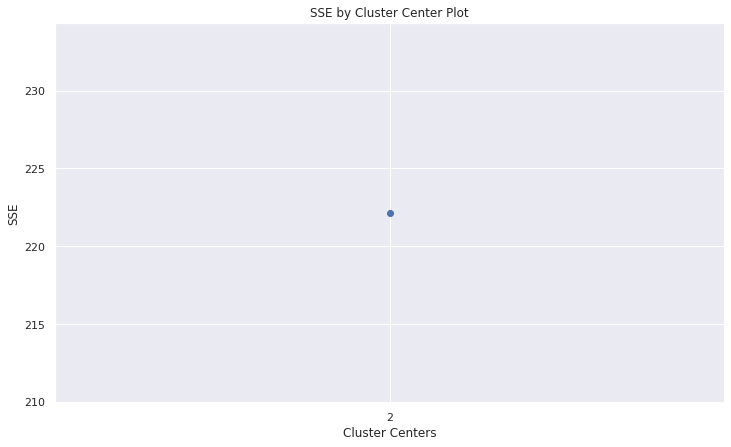

In [497]:
kmeans_for_a_class(subset_class(2))

In [98]:
keywords_list_c=extract_keywords_from_records(subset_class(1))

In [99]:
captions_list_c=["record"+str(i) for i in range(len(keywords_list_c))]
len(captions_list_c)

260

In [100]:
def pickup_a_record_for_print_c(number, line):
# now print the results
    print("\n=====Record class=====" + " "+ subsets_df[number]["prompt"].iloc[line])
    print(subset_class(number)[line])
    print("\n=====Asigned label=====")
    print(subsets_df[number]["prompt"].iloc[line])
    print("\n===Keywords===")
    display_side_by_side([keywords_list_c[line]], [captions_list_c[line]])

In [101]:
pickup_a_record_for_print_c(1, 1)


=====Record class===== Back pain
i feel a pain in my back

=====Asigned label=====
Back pain

===Keywords===


<p style='color:#af0fa2; font-size:30px; text-align:left'> <strong> Supervised ML studies 
    </strong>
</p>

<img src="supervised-classification.png" width="400" height="200">

In [289]:
transcript.head(2)

audio_clipping  audio_clipping:confidence background_noise_audible  \
0     no_clipping                     1.0000              light_noise   
1  light_clipping                     0.6803                 no_noise   

   background_noise_audible:confidence  overall_quality_of_the_audio  \
0                               1.0000                          3.33   
1                               0.6803                          3.33   

     quiet_speaker  quiet_speaker:confidence  speaker_id  \
0  audible_speaker                       1.0    43453425   
1  audible_speaker                       1.0    43719934   

                                       file_download  \
0  https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...   
1  https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...   

                       file_name  \
0  1249120_43453425_58166571.wav   
1  1249120_43719934_43347848.wav   

                                              phrase          prompt  \
0                    When I remember her I feel down  Emotional pain   
1  When I carry heavy things I feel like breaking...       Back pain   

   writer_id                                   phrase_transform  \
0   21665495                    When I remember her I feel down   
1   44088126  When I carry heavy things I feel like breaking...   

   record_words_count  
0                   7  
1                  11

In [290]:
trans_phr_analys_ml=transcript.copy()

In [291]:
trans_phr_analys_ml["phrase_transform"] = trans_phr_analys_ml["phrase_transform"].apply(lambda x: " ".join(x for x in tokenizer.tokenize(str(x))))

In [292]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [305]:
def preprocessing_records (text):
    
    translator = str.maketrans('', '', string.punctuation)
    text = text.lower().translate(translator) 
    text = re.sub("\\W+"," ",text) # remove special chars
    text = re.sub("</?.*?>"," <> ",text)
    text = re.sub('[^a-zA-Z]', ' ', text) #remove punctuations
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text) #remove tags
    text = text.replace("    ", " ")
    text = text.replace("'s", "") # remove possessive pronoun terminations
    
    
    words=re.split("\\s+",text)
#     words=nltk.word_tokenize(text)
    lem = WordNetLemmatizer() #Lemmatisation
    lema_words = [lem.lemmatize(word) for word in words if not word in stop_words_list] 
    return " ".join(lema_words)
    
     
#     stem words
#     stemmer=PorterStemmer()
#     words=re.split("\\s+",text)
#     stemmed_words=[stemmer.stem(word=word) for word in words if word not in stop_words_list]
#     return ' '.join(stemmed_words)

In [306]:
"medicine" in stop_words_list

True

In [307]:
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: str(x).strip().lower())
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(r'(?<=[,;])(?=[^\s])', r' ',str(x)))
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(r'\s([-,.;+:"](?:\s|$))', r'\1',str(x)))
trans_phr_analys_ml['phrase'] = trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(regex_string, "cannot", str(x), flags=re.I))
trans_phr_analys_ml['phrase'] = trans_phr_analys_ml["phrase"].apply(lambda x: re.sub(regex_string_2, "doesnot", str(x), flags=re.I))
trans_phr_analys_ml["phrase"]=trans_phr_analys_ml["phrase"].apply(lambda x: " ".join(x for x in tokenizer.tokenize(str(x))))

In [308]:
trans_phr_analys_ml['phrase_transform'].values[6659], trans_phr_analys_ml["phrase"].values[6659
                                                                                    ]

('The area around my heart doesnot feel good', 'area heart doesnot feel good')

In [309]:
trans_phr_analys_ml["phrase"] = trans_phr_analys_ml["phrase"].apply(lambda x:preprocessing_records(str(x)))

In [310]:
trans_phr_analys_ml["phrase"]

0                                      remember feel down
1                     carry heavy feel like breaking back
2                                                pain arm
3       lip pierced swollen skin inside lip grey infected
4                                muscle lower back aching
                              ...                        
6656                      feel burning sensation gut meal
6657                                     split thumb heal
6658                                  feel lot pain joint
6659                         area heart doesnot feel good
6660                                complain skin allergy
Name: phrase, Length: 6661, dtype: object

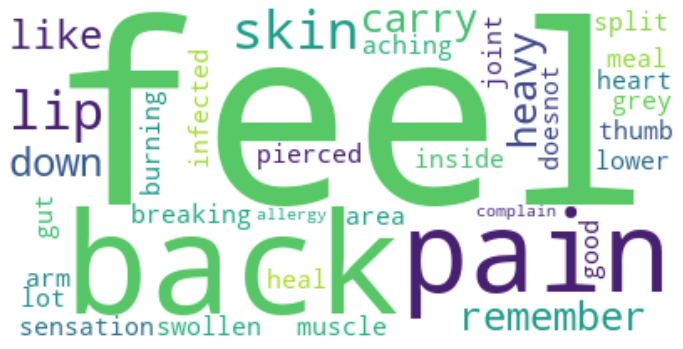

In [1042]:
#Word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words_list,
                          max_words=100,
                          max_font_size=150, 
                          random_state=42
                          ).generate(str(trans_phr_analys_ml["phrase"]))

print(wordcloud)
fig = plt.figure(1, figsize=(12, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

In [312]:
trans_phr_analys_ml["phrase"].values[17], transcript["phrase"].values[17]

('time finished reading feel head ache',
 'I read a book for along time and when I finished reading I feel head ache')

In [313]:
all_records=trans_phr_analys_ml["phrase"].tolist()
cv=CountVectorizer(max_df=0.85,stop_words=stop_words_list)
word_count_vector=cv.fit_transform(all_records)

In [314]:
trans_phr_analys_ml["phrase"]

0                                      remember feel down
1                     carry heavy feel like breaking back
2                                                pain arm
3       lip pierced swollen skin inside lip grey infected
4                                muscle lower back aching
                              ...                        
6656                      feel burning sensation gut meal
6657                                     split thumb heal
6658                                  feel lot pain joint
6659                         area heart doesnot feel good
6660                                complain skin allergy
Name: phrase, Length: 6661, dtype: object

In [315]:
len(set(list(cv.vocabulary_.items())))

865

In [316]:
#Most frequently occuring words
def get_top_n_words(records, n=None):
    vec = CountVectorizer().fit(records)
    bag_of_words = vec.transform(records)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

In [317]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(all_records, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Frequency"]
top_df.head(5)

Word  Frequency
0    feel       1813
1    pain       1634
2  cannot        596
3    hurt        526
4    like        507

[Text(0, 0, 'feel'),
 Text(0, 0, 'pain'),
 Text(0, 0, 'cannot'),
 Text(0, 0, 'hurt'),
 Text(0, 0, 'like'),
 Text(0, 0, 'back'),
 Text(0, 0, 'knee'),
 Text(0, 0, 'shoulder'),
 Text(0, 0, 'ache'),
 Text(0, 0, 'hair'),
 Text(0, 0, 'head'),
 Text(0, 0, 'cold'),
 Text(0, 0, 'body'),
 Text(0, 0, 'neck'),
 Text(0, 0, 'ear'),
 Text(0, 0, 'skin'),
 Text(0, 0, 'foot'),
 Text(0, 0, 'stomach'),
 Text(0, 0, 'heart'),
 Text(0, 0, 'lot')]

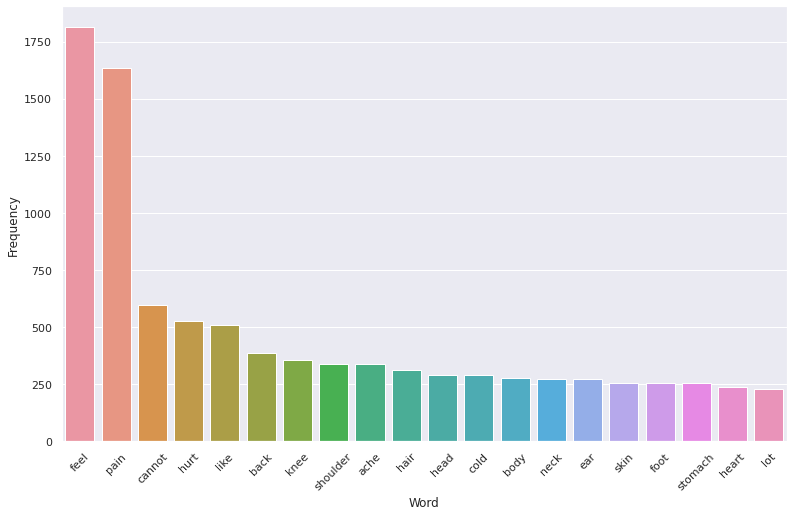

In [318]:
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Frequency", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)

          Bi-gram  Frequency
0       feel pain        316
1       feel like        305
2      sharp pain        181
3      feel dizzy        159
4       feel weak        117
5    hair falling        102
6   blurry vision         89
7       pain knee         85
8   shoulder pain         82
9       body feel         82
10      feel cold         80
11   pain stomach         79
12     great pain         78
13     feel great         75
14      pain back         65
15       ear ache         63
16      pain foot         63
17      back hurt         61
18   cannot stand         60
19     lower back         59


[Text(0, 0, 'feel pain'),
 Text(0, 0, 'feel like'),
 Text(0, 0, 'sharp pain'),
 Text(0, 0, 'feel dizzy'),
 Text(0, 0, 'feel weak'),
 Text(0, 0, 'hair falling'),
 Text(0, 0, 'blurry vision'),
 Text(0, 0, 'pain knee'),
 Text(0, 0, 'shoulder pain'),
 Text(0, 0, 'body feel'),
 Text(0, 0, 'feel cold'),
 Text(0, 0, 'pain stomach'),
 Text(0, 0, 'great pain'),
 Text(0, 0, 'feel great'),
 Text(0, 0, 'pain back'),
 Text(0, 0, 'ear ache'),
 Text(0, 0, 'pain foot'),
 Text(0, 0, 'back hurt'),
 Text(0, 0, 'cannot stand'),
 Text(0, 0, 'lower back')]

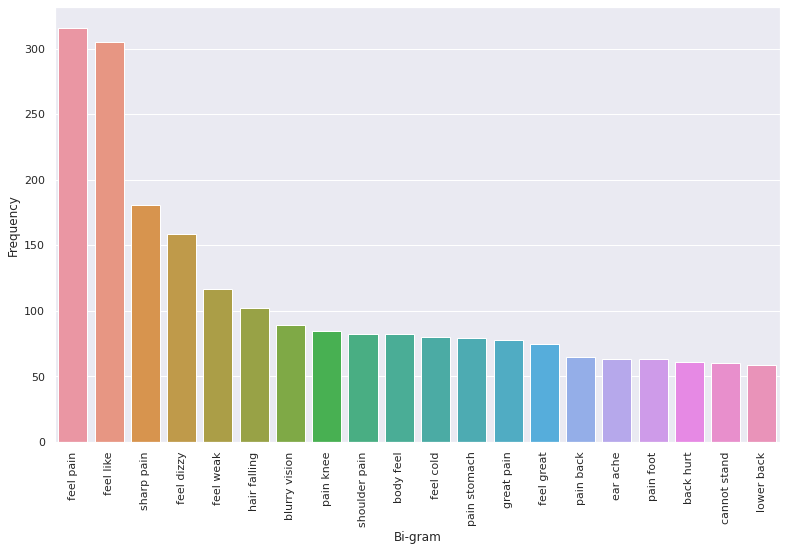

In [319]:
#Most frequently occuring Bi-grams
def get_top_n2_words(records, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(records)
    bag_of_words = vec1.transform(records)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]


top2_words = get_top_n2_words(all_records, n=20)


top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Frequency"]

print(top2_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Frequency", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90)

https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

In [320]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
tfidf_transformer.idf_

array([6.54607848, 7.0315863 , 7.50158993, 7.85826487, 6.91380326,
       7.50158993, 6.85973604, 3.9752294 , 5.97553362, 4.71657868,
       6.80844275, 7.72473348, 7.60695044, 7.40627975, 7.60695044,
       7.60695044, 6.11529556, 7.40627975, 7.72473348, 7.31926837,
       7.40627975, 7.50158993, 5.27157553, 7.50158993, 7.40627975,
       7.40627975, 7.85826487, 7.31926837, 6.62612119, 7.85826487,
       7.31926837, 7.60695044, 6.33843912, 4.8205684 , 7.60695044,
       7.85826487, 6.75965258, 7.23922566, 7.23922566, 5.77882333,
       7.40627975, 7.40627975, 3.84575033, 5.77882333, 5.67704063,
       7.60695044, 7.50158993, 6.91380326, 6.47197051, 6.37018781,
       7.40627975, 7.31926837, 7.40627975, 7.60695044, 7.40627975,
       7.23922566, 5.47344168, 7.50158993, 5.67704063, 6.43687919,
       7.60695044, 6.33843912, 7.0315863 , 7.50158993, 7.50158993,
       7.40627975, 6.0665054 , 6.58529919, 7.40627975, 7.31926837,
       7.50158993, 5.11282714, 4.18377415, 6.43687919, 6.85973

In [321]:
keywords_list=extract_keywords_from_records(all_records)

In [322]:
captions_list_=["record"+str(i) for i in range(len(keywords_list))]
len(captions_list)

6661

In [323]:
def pickup_a_record_for_print(number):
# now print the results
    print("\n=====Record=====")
    print(all_records[number])
    print("\n=====Asigned label=====")
    print(trans_phr_analys["prompt"].iloc[number])
    print("\n===Keywords===")
    display_side_by_side([keywords_list[number]], [captions_list[number]])

In [324]:
pickup_a_record_for_print(4)


=====Record=====
muscle lower back aching

=====Asigned label=====
Muscle pain

===Keywords===


In [397]:
n=input("Picup a record to print ")
pickup_a_record_for_print(int(n))

Picup a record to print 34

=====Record=====
feel like claw chest leaf breathless

=====Asigned label=====
Hard to breath

===Keywords===


<p style='color:#af0fa2; font-size:22px; text-align:left'> <strong> Encoding  </strong>
</p>

In [326]:
text_labels = trans_phr_analys_ml[["phrase", "prompt"]]

In [659]:
X = trans_phr_analys_ml["phrase"]
y = trans_phr_analys_ml["prompt"]

In [602]:
trans_phr_analys_ml["prompt"].head(2)

0    Emotional pain
1         Back pain
Name: prompt, dtype: object

In [729]:
type(X)

pandas.core.series.Series

In [660]:
le = LabelEncoder()
y=le.fit_transform(y)

In [661]:
lb = LabelBinarizer()
y_binarizer=lb.fit_transform(y)
y_binarizer

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [662]:
# Binarize the output variable
y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
n_classes = y.shape[1]

In [663]:
is_all_zero = np.all((y == 0))
is_all_zero

False

In [1164]:
X

0                                      remember feel down
1                     carry heavy feel like breaking back
2                                                pain arm
3       lip pierced swollen skin inside lip grey infected
4                                muscle lower back aching
                              ...                        
6656                      feel burning sensation gut meal
6657                                     split thumb heal
6658                                  feel lot pain joint
6659                         area heart doesnot feel good
6660                                complain skin allergy
Name: phrase, Length: 6661, dtype: object

In [664]:
label_classes = {k:v for k,v in zip(list(trans_phr_analys_ml["prompt"]),y_binarizer.tolist())}

In [515]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_binarizer, 
                                                    test_size=0.2, 
                                                    random_state=42, stratify=y)

In [976]:
X_train

5720                      eating burning sensation inside
974     acne problem pregnancy sudden back got covered...
5411                             cluster pimple face away
5731    cut hand couple week ago antibiotic cream gett...
4715                        internal pain cannot describe
                              ...                        
4270                        cannot see sign blurry vision
4912    feel like hitting head hammer feel pain head t...
85                                             dry throat
6358    visited doctor cannot find right treatment tog...
4246                                       know feel cold
Name: phrase, Length: 5328, dtype: object

> TF-IDF Vectors are used as features 

In [731]:
type(X_train)

pandas.core.series.Series

In [516]:
tfidf_vectorizer  = TfidfVectorizer(min_df=2, 
                                    stop_words=None, 
                                    encoding='utf-8',
                                    ngram_range=(1,1),
                                    lowercase=False,
                                    use_idf=True, 
                                    smooth_idf=True)

X_features_train = tfidf_vectorizer.fit_transform(X_train).toarray()
y_labels_train = y_train

print(X_features_train.shape)

X_features_test = tfidf_vectorizer.transform(X_test).toarray()
y_labels_test = y_test
print(X_features_test.shape)

(5328, 863)
(1333, 863)


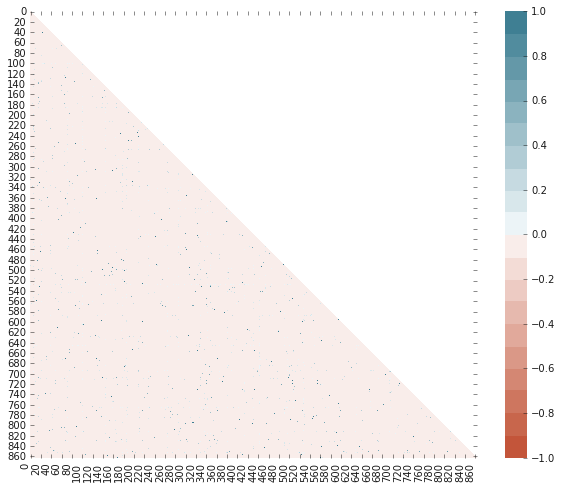

In [1166]:
fig, ax = plt.subplots(figsize=(10, 8))
corr = pd.DataFrame(X_features_train).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=20),
    square=True, mask=mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [1058]:
# Save the model as a pickle file
filename_pkl_tfidf = './tfidf.pkl'
dump(tfidf_vectorizer, filename_pkl_tfidf)

['./tfidf.pkl']

In [517]:
tfidf_vectorizer.get_feature_names()

['abdomen',
 'abdominal',
 'able',
 'abronchial',
 'accident',
 'accidentally',
 'accompanied',
 'ache',
 'aching',
 'acne',
 'active',
 'actually',
 'acupuncture',
 'adult',
 'affected',
 'afraid',
 'ago',
 'agreat',
 'air',
 'allergy',
 'analysis',
 'anemia',
 'ankle',
 'annoyance',
 'annoying',
 'annoys',
 'answer',
 'antibiotic',
 'anymore',
 'anytime',
 'appendicitis',
 'arch',
 'area',
 'arm',
 'arrived',
 'asthma',
 'ate',
 'attack',
 'awake',
 'away',
 'awful',
 'bacause',
 'back',
 'bad',
 'badly',
 'bald',
 'ball',
 'barely',
 'basketball',
 'bear',
 'beating',
 'bed',
 'beeing',
 'beginning',
 'believe',
 'belly',
 'bend',
 'bent',
 'better',
 'bicep',
 'biceps',
 'big',
 'bike',
 'bit',
 'blackhead',
 'blanket',
 'bleeding',
 'bloating',
 'blood',
 'blur',
 'blurred',
 'blurry',
 'body',
 'bone',
 'bother',
 'bowel',
 'brain',
 'break',
 'breaking',
 'breakout',
 'breakup',
 'breath',
 'breathe',
 'breathing',
 'breathless',
 'bright',
 'broke',
 'broken',
 'brow',
 'brush'

> $\Chi^{2}$ test in order to see what unigrams are most correlated with each labels'class.

In [1043]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, label_id in sorted(label_classes.items()):
    features_chi2 = chi2(X_features_train, y_labels_train == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-10:])))
    print("")

# 'Acne' category:
  . Most correlated unigrams:
. gland
. sebaceous
. follicle
. whitehead
. cluster
. patch
. disease
. pimple
. face
. acne

# 'Back pain' category:
  . Most correlated unigrams:
. chair
. standing
. shooting
. dwwls
. annoys
. spine
. tie
. lower
. bend
. back

# 'Blurry vision' category:
  . Most correlated unigrams:
. car
. cloudy
. seeing
. fog
. driving
. quick
. eye
. see
. blurry
. vision

# 'Body feels weak' category:
  . Most correlated unigrams:
. bed
. stength
. fragile
. exhausted
. impression
. strength
. tired
. energy
. body
. weak

# 'Cough' category:
  . Most correlated unigrams:
. tickle
. child
. congestion
. smoker
. lung
. breathe
. mucus
. coughing
. throat
. cough

# 'Ear ache' category:
  . Most correlated unigrams:
. listening
. showering
. plane
. travelled
. forest
. ringing
. tinnitus
. unbearable
. hearing
. ear

# 'Emotional pain' category:
  . Most correlated unigrams:
. cheer
. constantly
. disterbance
. emotion
. emotionally
. remembe

<p style='color:#af0fa2; font-size:25px; text-align:left'> <strong> Random forest  </strong>
</p>

In [519]:
clf=RandomForestClassifier(random_state = 42)
print('Parameters currently in use:\n')
pprint(clf.get_params())
classifier = OneVsRestClassifier(clf)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [521]:
classifier.fit(X_features_train, y_labels_train)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [528]:
classifier.n_classes_

25

In [1018]:
y_score = classifier.predict_proba(X_features_test)

In [1028]:
y_score[2]

array([0.01, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  ])

In [531]:
y_pred=classifier.predict(X_features_test)

In [532]:
y_test_non_category = [ np.argmax(t) for t in y_labels_test ]
y_pred_non_category = [ np.argmax(t) for t in y_pred ]

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_non_category, y_pred_non_category)

In [537]:
def plot_cm(cm, title, classes, normalize=False):

    plt.imshow(cm, interpolation='nearest', cmap="Blues")
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    
    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=12)

In [543]:
plt.style.use('classic')
class_names = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]

In [687]:
label_classes.keys()

dict_keys(['Emotional pain', 'Back pain', 'Heart hurts', 'Infected wound', 'Muscle pain', 'Foot ache', 'Injury from sports', 'Skin issue', 'Stomach ache', 'Knee pain', 'Hard to breath', 'Head ache', 'Feeling cold', 'Hair falling out', 'Feeling dizzy', 'Open wound', 'Internal pain', 'Body feels weak', 'Blurry vision', 'Acne', 'Joint pain', 'Shoulder pain', 'Neck pain', 'Cough', 'Ear ache'])

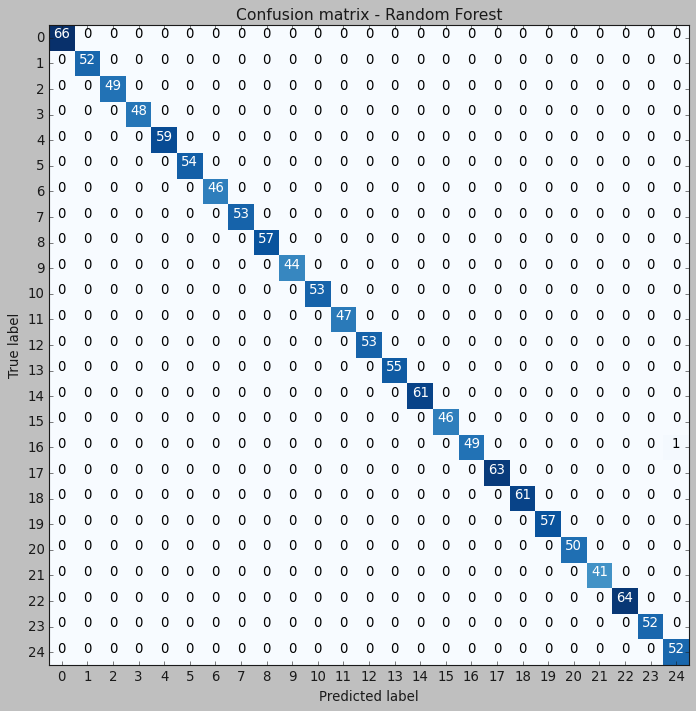

In [562]:
fig = plt.figure(figsize = (22,10))
plot_cm(conf_mat, "Confusion matrix - Random Forest", class_names, normalize=False)

In [534]:
classifier.score(X_features_test, y_labels_test)

0.9992498124531133

In [591]:
print("Score within train :",classifier.score(X_features_train,y_labels_train))
print("Score within test :",classifier.score(X_features_test, y_labels_test))

Score within train : 0.9983108108108109
Score within test : 0.9992498124531133


In [590]:
 classifier.predict_proba(X_features_test)

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [595]:
 classifier.get_params(deep=True)

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(random_state=42),
 'n_jobs': None}

- n_estimators = number of trees in the forest.
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)



In [592]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [593]:
# create the model to tune
clf = RandomForestClassifier(random_state=42)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=clf,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_features_train, y_labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 54.2min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=8, scoring='accuracy', verbose=1)

In [594]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.9956831831831833


In [598]:
# Create the parameter grid based on the results of random search 
bootstrap = [True]
max_depth = [None]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [3, 5, 7]
n_estimators = [100, 300, 600]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

In [599]:
# Create a base model
clf = RandomForestClassifier(random_state=42)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_features_train, y_labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 13.1min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=42, test_size=0.33, train_size=None),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'max_depth': [None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [100, 300, 600]},
             scoring='accuracy', verbose=1)

In [600]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

The mean accuracy of a model with these hyperparameters is:
0.9965889710062535


In [605]:
best_clf = grid_search.best_estimator_
best_clf

RandomForestClassifier(max_features='sqrt', min_samples_split=3,
                       random_state=42)

In [603]:
clf_optim=RandomForestClassifier(random_state = 42, max_depth=None, max_features="sqrt",
                           min_samples_leaf=1,min_samples_split=3,n_estimators=100,
                           bootstrap=True)
print('Parameters currently in use:\n')
pprint(clf_optim.get_params())
classifier = OneVsRestClassifier(clf_optim)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [606]:
classifier.fit(X_features_train, y_labels_train)

OneVsRestClassifier(estimator=RandomForestClassifier(max_features='sqrt',
                                                     min_samples_split=3,
                                                     random_state=42))

In [607]:
y_pred=classifier.predict(X_features_test)

In [608]:
y_score = classifier.predict_proba(X_features_test)

In [609]:
print("Score within train :",classifier.score(X_features_train,y_labels_train))
print("Score within test :",classifier.score(X_features_test, y_labels_test))

Score within train : 0.9983108108108109
Score within test : 0.9992498124531133


In [610]:
import pickle
clf_optimized = pickle.dumps(classifier) 
rfclf_optimized =pickle.dumps(clf_optim)

In [1039]:
from joblib import dump, load
filename_1='./rfonevall.joblib'
dump(classifier, filename_1) 

['./rfonevall.joblib']

In [1040]:
filename='./rf_optimized.joblib'
dump(clf_optimized, filename) 

['./rf_optimized.joblib']

In [1041]:
# Save the model as a pickle file
filename_pkl = './rfonevall.pkl'
dump(classifier, filename_pkl)

# # Load the model from the file
# model_rf_pk = load(filename_fkl)

['./rfonevall.pkl']

In [614]:
from sklearn.metrics import classification_report 
print(classification_report(y_labels_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        52
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        48
           4       1.00      1.00      1.00        59
           5       1.00      1.00      1.00        54
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        53
           8       1.00      1.00      1.00        57
           9       1.00      1.00      1.00        44
          10       1.00      1.00      1.00        53
          11       1.00      1.00      1.00        47
          12       1.00      1.00      1.00        53
          13       1.00      1.00      1.00        55
          14       1.00      1.00      1.00        61
          15       1.00      1.00      1.00        46
          16       1.00      0.98      0.99        50
          17       1.00    

In [712]:
print("Random Forests accuracy - train", accuracy_score(y_labels_train, classifier.predict(X_features_train)))
print("Random Forests accuracy - test ", accuracy_score(y_labels_test, y_pred))
# print("Random Forests recall", recall_score(y_labels_test, y_pred))
# print("Random Forests f1_score", f1_score(y_labels_test, y_pred))

Random Forests accuracy - train 0.9983108108108109
Random Forests accuracy - test  0.9992498124531133


>Feature Importances

>The feature importances in a random forest indicate the sum of the reduction in Gini Impurity over all the nodes that are split on that feature. We can use these to try and figure out what predictor variables the random forest considers most important. The feature importances can be extracted from a trained random forest and put into a Pandas dataframe as follows.

In [649]:
X_features_train_df=pd.DataFrame(X_features_train)

In [652]:
X_features_train_df.head(2)

0    1    2    3    4    5    6    7    8       9    ...  853  854  855  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0000  ...  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2647  ...  0.0  0.0  0.0   

   856  857  858  859  860  861       862  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.433823  

[2 rows x 863 columns]

In [654]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(X_features_train_df),
                   'importance': best_clf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

feature  importance
226      226    0.030472
647      647    0.027946
327      327    0.027350
414      414    0.025893
498      498    0.025234
404      404    0.024536
343      343    0.024009
287      287    0.023342
710      710    0.022564
42        42    0.021597

In [1174]:
X_features_train.shape + X_features_test.shape

(5328, 863, 1333, 863)

In [1170]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_labels_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_labels_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [1175]:
label_dict = {value : key for (key, value) in label_classes.items()}

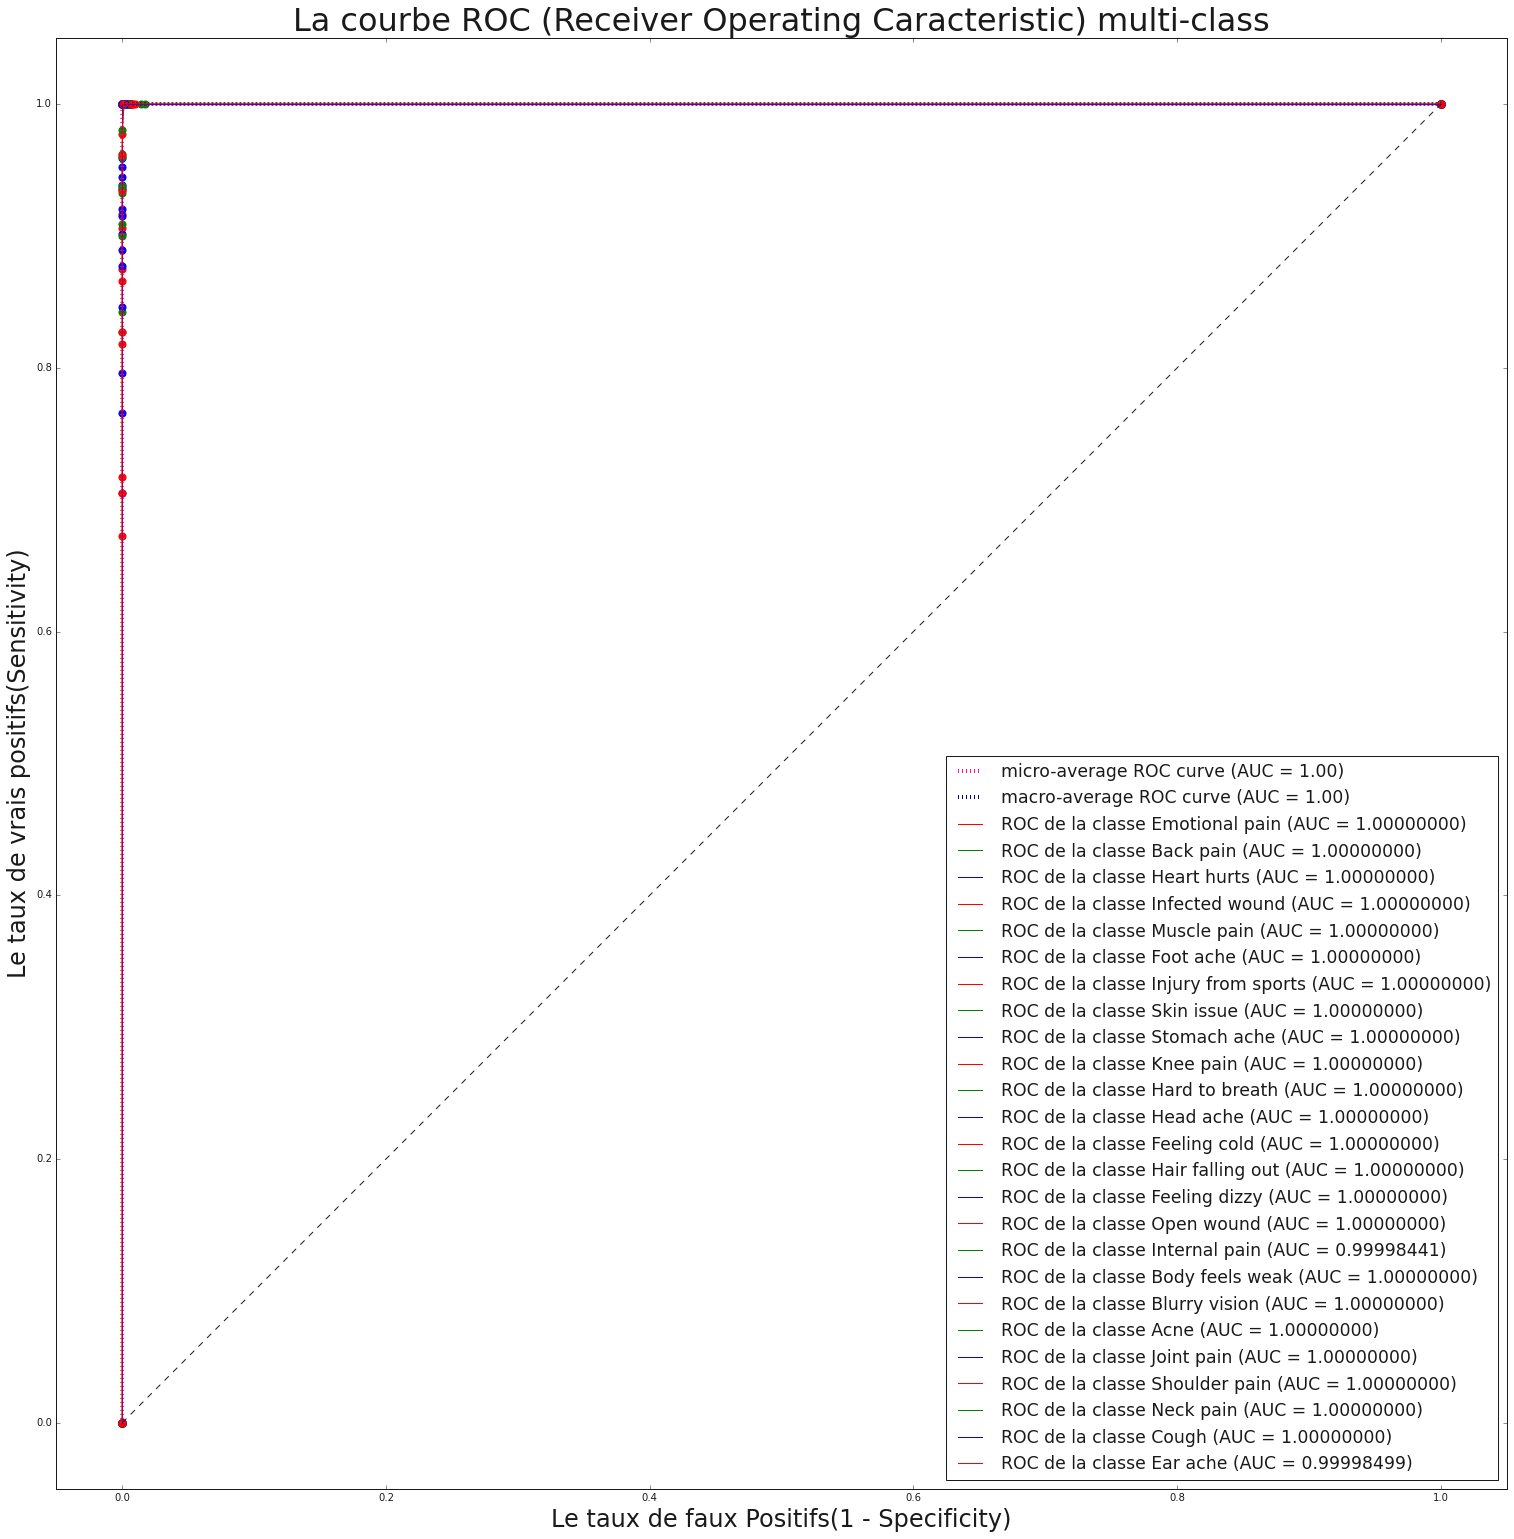

In [1176]:
from numpy import interp
from itertools import cycle
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure(figsize=(26,26))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['red', 'green', 'blue'])

label_dict = {value : key for (value, key) in label_classes.items()}
lw = 1
for i, color in zip(range(n_classes), colors):
    plt.scatter( fpr[i], tpr[i], color=color, s=50)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC de la classe '+list(label_dict.keys())[i]+' (AUC = {1:0.8f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Le taux de faux Positifs(1 - Specificity)',size=24)
plt.ylabel('Le taux de vrais positifs(Sensitivity)',size=24)
plt.title('La courbe ROC (Receiver Operating Caracteristic) multi-class',size=32)
plt.legend(loc="lower right", fontsize = 'xx-large')
plt.show()

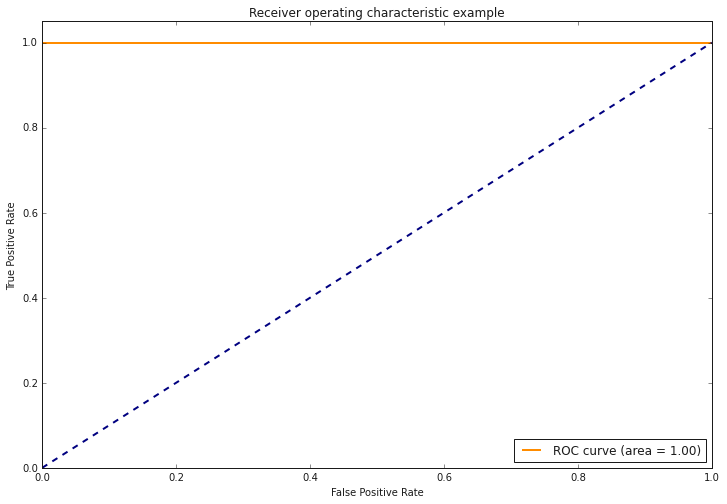

In [711]:
plt.figure(figsize=(12,8))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [716]:
transcript.head(1)

audio_clipping  audio_clipping:confidence background_noise_audible  \
0    no_clipping                        1.0              light_noise   

   background_noise_audible:confidence  overall_quality_of_the_audio  \
0                                  1.0                          3.33   

     quiet_speaker  quiet_speaker:confidence  speaker_id  \
0  audible_speaker                       1.0    43453425   

                                       file_download  \
0  https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...   

                       file_name                           phrase  \
0  1249120_43453425_58166571.wav  When I remember her I feel down   

           prompt  writer_id                 phrase_transform  \
0  Emotional pain   21665495  When I remember her I feel down   

   record_words_count  
0                   7

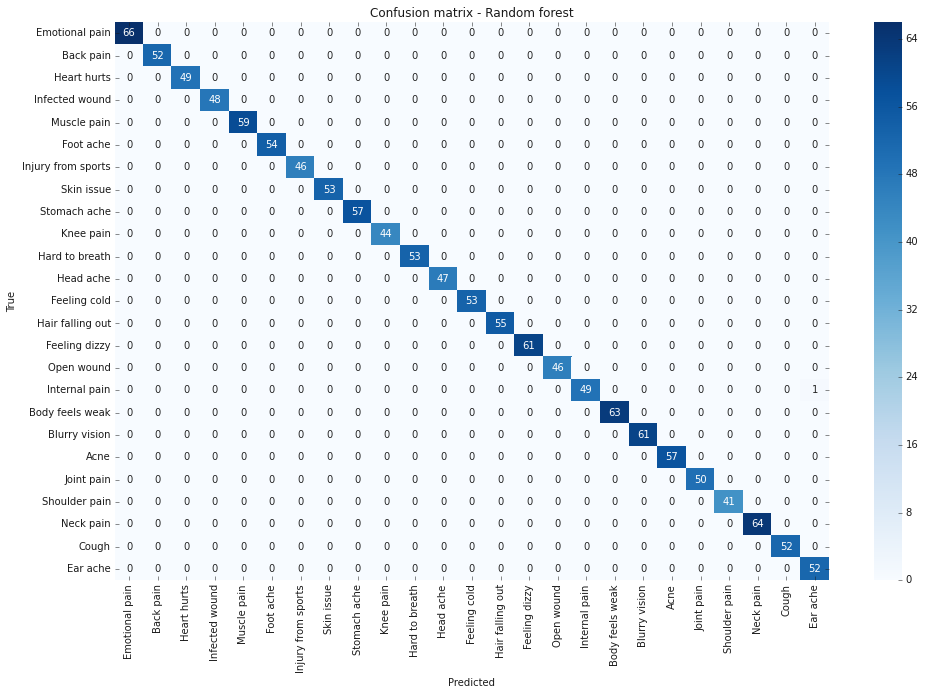

In [723]:
conf_matrix= confusion_matrix(y_test_non_category, y_pred_non_category)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=list(label_dict.keys()), 
            yticklabels=list(label_dict.keys()),
            cmap="Blues")
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion matrix - Random forest')
plt.show()

<p style='color:#af0fa2; font-size:25px; text-align:left'> <strong> Prédiction  </strong>
</p>

In [1075]:
import os

path=os.path.join(os.getcwd(), "rfonevall.pkl")
path

'/home/alex/SimplonIA/Enfer/Projet_ML/rfonevall.pkl'

In [1163]:
import os

def prediction_symptom_from_phrase(phrase):
    
    
    path=os.path.join(os.getcwd(), "rfonevall.pkl")
    path_tfidf=os.path.join(os.getcwd(), "tfidf.pkl")
    
    print(phrase)
    
    tfidf=load(path_tfidf)
    model_rf=load(path)
    
    phrase=preprocessing_records(phrase)
    
    print(phrase)
    
    
    X_phrase_apredire = tfidf.transform(pd.Series(str(phrase))).toarray()

    y_phrase_apredir=model_rf.predict(X_phrase_apredire)
    print(y_phrase_apredir)
    
    label_classes={'Emotional pain': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Back pain': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Heart hurts': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Infected wound': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Muscle pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     'Foot ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Injury from sports': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Skin issue': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 
     'Stomach ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
     'Knee pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 
     'Hard to breath': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Head ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Feeling cold': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Hair falling out': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Feeling dizzy': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Open wound': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 
     'Internal pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Body feels weak': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Blurry vision': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     'Acne': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Joint pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'Shoulder pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'Neck pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'Cough': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Ear ache': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

    symptom=''
    for col in pd.DataFrame.from_dict(label_classes).columns:
        if (pd.DataFrame.from_dict(label_classes)[col].equals(pd.Series(y_phrase_apredir[0]))):
            print("The symptom is " + col)
            symptom=col
            break
            return symptom
        else:
            continue
    if not symptom :
        return "We could not define your symptom"

response=input("What is your complain ? ")
prediction_symptom_from_phrase(response)

What is your complain ? Alex fait un dodo
Alex fait un dodo
alex fait un dodo
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
The symptom is Heart hurts


In [1147]:
phrase=input("What is your complain ")
phrase=preprocessing_records(phrase)
print(phrase)
X_phrase_apredire = tfidf_vectorizer.transform(pd.Series(str(phrase))).toarray()

What is your complain I have a chest pain
chest pain


In [1141]:
model_rf=load(filename_1)
model_rf

OneVsRestClassifier(estimator=RandomForestClassifier(max_features='sqrt',
                                                     min_samples_split=3,
                                                     random_state=42))

In [1148]:
y_phrase_apredir=model_rf.predict(X_phrase_apredire)

In [1149]:
y_phrase_apredir

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]])

In [1144]:
pd.set_option('display.max_columns', 30)
pd.DataFrame.from_dict(label_classes).columns

Index(['Emotional pain', 'Back pain', 'Heart hurts', 'Infected wound',
       'Muscle pain', 'Foot ache', 'Injury from sports', 'Skin issue',
       'Stomach ache', 'Knee pain', 'Hard to breath', 'Head ache',
       'Feeling cold', 'Hair falling out', 'Feeling dizzy', 'Open wound',
       'Internal pain', 'Body feels weak', 'Blurry vision', 'Acne',
       'Joint pain', 'Shoulder pain', 'Neck pain', 'Cough', 'Ear ache'],
      dtype='object')

In [1150]:
list_symptoms=pd.Series(pd.DataFrame.from_dict(label_classes).columns)
list_symptoms[0]

'Emotional pain'

In [1146]:
for col in pd.DataFrame.from_dict(label_classes).columns:
    if (pd.DataFrame.from_dict(label_classes)[col].equals(pd.Series(y_phrase_apredir[0]))):
        print("The symptom is " + col)
#         break
#     else:
#         print("Can not define the symptom")

The symptom is Heart hurts


In [1119]:
print(label_classes)

{'Emotional pain': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Back pain': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Heart hurts': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Infected wound': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Muscle pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'Foot ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Injury from sports': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Skin issue': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'Stomach ache': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'Knee pain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'Hard to breath': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [1059]:
subset_class(2)[1:30]

['dr i feel a strange and powerful pain inside my rib cage',
 'i have for dia',
 'i often get a sharp pain in my chest and i cannot tell what i m doing that might be triggering it',
 'my heart is beating fast and it scares me',
 'i feel heart pain when i walk a lot',
 'i have a great pain in my thorax from heart injury',
 'i feel increased heart rate with prick',
 'i feel increased heart rate with prick',
 'heart aches so much',
 'it is like i have a needle pushing through my heart',
 'i feel a pain on the left side of my chest where my heart is',
 'i feel pain in my heart when i wake up',
 'i often get a sharp pain in my chest and i cannot tell what i m doing that might be triggering it',
 'there is this pain that radiates from my chest up to my left arm',
 'my heart hurts while i m sad why',
 'my husband left me for another woman my heart hurts so badly to the point i cannot eat or sleep',
 'oh my heart hurts me i tried to be calm and i cannot',
 'i feel hurts in my heart',
 'my hear